In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
try:
    from OSCC_postprocessing.playback.video_playback import *
except ModuleNotFoundError:
    import sys
    from pathlib import Path

    # Try to prepend any parent directory that contains the package
    cwd = Path().resolve()
    for parent in [cwd] + list(cwd.parents):
        if (parent / "OSCC_postprocessing").is_dir():
            sys.path.insert(0, str(parent))
            break
    else:
        # Fallback to a likely project path (adjust if needed)
        fallback = Path(r"c:\Users\LJI008\Mie_Postprocessing_Py")
        if fallback.is_dir():
            sys.path.insert(0, str(fallback))
        else:
            raise

    from OSCC_postprocessing.playback.video_playback import *

Z:\Lab_doc\OSCC\Research Projects\2025 - MeOH temperature Impact\Preparations
 

In [80]:
# load boundary points
file_path = r"G:\MeOH_test\Mie\Processed_Results\Postprocessed_Data\T32_Mie Camera_1_boundary_points.csv"
boundary_bw = pd.read_csv(file_path)

In [82]:
# Foreground npz
npz = np.load(r"G:\MeOH_test\Mie\Processed_Results\Rotated_Videos\T32_Mie Camera_1_foreground.npz", allow_pickle=True)

# get the actual array stored inside the .npz (prefer the 'foreground' key if present)
if "foreground" in npz.files:
	foreground = npz["foreground"]
elif len(npz.files) == 1:
	foreground = npz[npz.files[0]]
else:
	raise KeyError(f"Could not determine which array to use from {npz.files!r}")

# handle 3D (F, H, W) or 4D (F, H, W, C) arrays
if foreground.ndim == 3:
	F, H, W = foreground.shape
elif foreground.ndim == 4:
	F, H, W = foreground.shape[:3]
else:
	raise ValueError(f"Unexpected foreground array shape: {foreground.shape}")



In [83]:
foreground.shape

(200, 253, 760)

In [84]:
# define a simple play_video_cv2 for Jupyter notebooks (in-notebook playback)
# Reuses already-imported plt and np from earlier cells.
from IPython.display import display, clear_output

def play_video(frames, fps=20, cmap='gray'):
	"""
	Play a sequence of frames inline in the notebook.
	frames: numpy array with shape (F, H, W) or (F, H, W, C)
	fps: frames per second
	"""
	if not hasattr(frames, "ndim"):
		raise TypeError("frames must be a numpy array-like")
	F = frames.shape[0]
	# determine display range from frames to keep contrast consistent
	try:
		vmin = float(np.nanpercentile(frames, 1))
		vmax = float(np.nanpercentile(frames, 99))
	except Exception:
		vmin, vmax = None, None

	fig = plt.figure(figsize=(6, 6 * frames.shape[1] / frames.shape[2]))
	for i in range(F):
		img = frames[i]
		plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
		plt.axis('off')
		display(plt.gcf())
		plt.pause(1.0 / fps)
		clear_output(wait=True)
	plt.close(fig)

# play the video
# play_video(foreground)

In [85]:
# Display the data structure
boundary_bw.head()

,frame,point_idx,y,x
0,16,0,-4.0,0.0
1,16,1,-4.0,1.0
2,16,2,-4.0,2.0
3,16,3,-4.0,3.0
4,16,4,-4.0,4.0


In [86]:
# creates a GroupBy object.
grouped = boundary_bw.groupby("frame")

last_frame = boundary_bw["frame"].max()

boundary_list = [[] for _ in range(last_frame + 1)]


 

In [87]:
grouped = boundary_bw.groupby("frame")

last_frame = boundary_bw["frame"].max()
boundary_list = [None] * (last_frame + 1)  # pre-allocate

for frame, group in grouped:
    # (n, 2) array: [[x0, y0],
    #               [x1, y1], ...]
    boundary_list[frame] = group[["x", "y"]].to_numpy()


(np.float64(-5.65), np.float64(118.65), np.float64(109.8), np.float64(136.2))

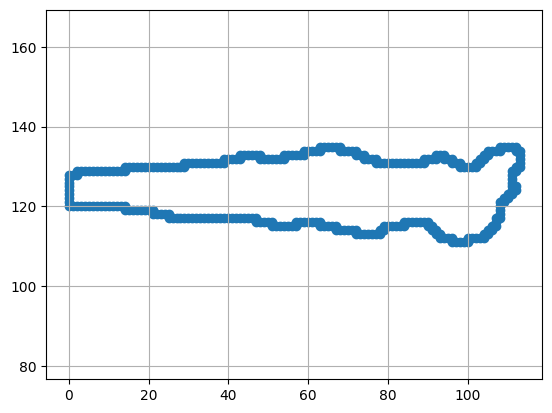

In [88]:
f = 25
plt.scatter(boundary_list[f][:,0], boundary_list[f][:,1]+H//2)
plt.xlim((0, W))
# plt.ylim((-H//2, H//2)) 
plt.grid()
plt.axis('equal')

In [89]:
pts = boundary_list[f].copy()              # shape (N, 2) as [x, y]
x = pts[:, 0]
y = pts[:, 1] + H//2                       # shift into image coordinates

# optional: round and clip
x = np.clip(np.rint(x).astype(np.int32), 0, W-1)
y = np.clip(np.rint(y).astype(np.int32), 0, H-1)

# integer contour points in (x, y)
contour_xy = np.column_stack([x, y])       # shape (N, 2)

(np.float64(-0.5), np.float64(759.5), np.float64(252.5), np.float64(-0.5))

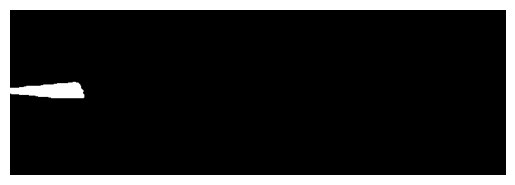

In [90]:
import numpy as np
import cv2

bw = np.zeros((H, W), dtype=np.uint8)

# OpenCV expects shape (N, 1, 2) with integer coords (x, y)
contour_cv = contour_xy.reshape(-1, 1, 2).astype(np.int32)

# Fill inside contour
cv2.fillPoly(bw, [contour_cv], 255)

plt.imshow(bw, cmap='gray')
plt.axis('off')
# (optional) draw the border too
# cv2.polylines(bw, [contour_cv], isClosed=True, color=255, thickness=1)

(np.float64(-0.5), np.float64(759.5), np.float64(252.5), np.float64(-0.5))

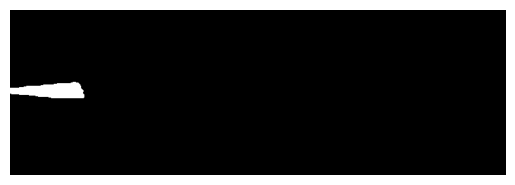

In [91]:
import numpy as np
from skimage.draw import polygon

bw = np.zeros((H, W), dtype=np.uint8)

# polygon wants row, col = y, x
rr, cc = polygon(y, x, shape=bw.shape)
bw[rr, cc] = 255

plt.imshow(bw, cmap='gray')
plt.axis('off') 

In [92]:
bw_video = np.zeros((F, H, W), dtype=np.uint8)

for frame, group in grouped:
    # (n, 2) array: [[x0, y0],
    #               [x1, y1], ...]
    boundary_list[frame] = group[["x", "y"]].to_numpy()
    pts = boundary_list[frame]              # shape (N, 2) as [x, y]
    x = pts[:, 0]
    y = pts[:, 1] + H//2                     # shift into image coordinates

    # optional: round and clip
    x = np.clip(np.rint(x).astype(np.int32), 0, W-1)
    y = np.clip(np.rint(y).astype(np.int32), 0, H-1)

    # integer contour points in (x, y)
    contour_xy = np.column_stack([x, y])       # shape (N, 2)
    contour_cv = contour_xy.reshape(-1, 1, 2).astype(np.int32)
    bw_video[frame] = cv2.fillPoly(bw_video[frame], [contour_cv], 255)


In [93]:
# play_video(bw_video)

In [94]:
def load_boundary_file(file_path, return_BW_video=False, F:int=0, H:int=0, W:int=0):
    """
    Load boundary points from CSV (must include frame/x/y).
    Returns:
    1) boundary_list: boundary points per frame (missing frames stay None)
    2) optional bw_video: filled binary masks per frame (0/255)
    """
    # If binary video output is required, dimensions must be valid.
    if return_BW_video and not (F > 0 and H > 0 and W > 0):
        raise ValueError("When return_BW_video=True, F/H/W must be positive.")

    boundary_bw = pd.read_csv(file_path)

    # Validate required columns to prevent KeyError later.
    required_cols = {"frame", "x", "y"}
    missing_cols = required_cols - set(boundary_bw.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {sorted(missing_cols)}")

    # Empty input: return empty list and optional empty video buffer.
    if boundary_bw.empty:
        bw_video = np.zeros((F, H, W), dtype=np.uint8) if return_BW_video else None
        return bw_video, []

    grouped = boundary_bw.groupby("frame", sort=True)

    # Pre-allocate by max frame index; missing frames remain None.
    last_frame = int(boundary_bw["frame"].max())
    boundary_list = [None] * (last_frame + 1)

    # OpenCV fill operations are best done on uint8.
    bw_video = np.zeros((F, H, W), dtype=np.uint8) if return_BW_video else None

    for frame, group in grouped:
        frame = int(frame) # type: ignore

        # Keep original boundary points as (N, 2) => [x, y].
        pts = group[["x", "y"]].to_numpy(dtype=np.float32)
        boundary_list[frame] = pts # type: ignore

        if not return_BW_video:
            continue

        # Skip drawing when CSV frame is outside provided video length.
        if frame < 0 or frame >= F:
            continue

        # Shift y by H//2 to map boundary coordinates into image coordinates.
        x = np.clip(np.rint(pts[:, 0]).astype(np.int32), 0, W - 1)
        y = np.clip(np.rint(pts[:, 1] + H // 2).astype(np.int32), 0, H - 1)

        # Draw boundary pixels first (order-independent).
        edge = np.zeros((H, W), dtype=np.uint8)
        edge[y, x] = 255

        # Close tiny gaps on the boundary so flood fill does not leak in.
        edge = cv2.morphologyEx(edge, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))

        # Flood-fill on a padded canvas so boundaries touching image edges do not leak.
        edge_pad = np.zeros((H + 2, W + 2), dtype=np.uint8)
        edge_pad[1:-1, 1:-1] = edge

        ff = edge_pad.copy()
        flood_mask = np.zeros((H + 4, W + 4), dtype=np.uint8)
        cv2.floodFill(ff, flood_mask, (0, 0), 255)

        # In padded domain: interior = not(outside) and not(boundary)
        outside = ff
        interior_pad = cv2.bitwise_and(cv2.bitwise_not(outside), cv2.bitwise_not(edge_pad))

        # Crop back to original size and merge with boundary.
        filled = interior_pad[1:-1, 1:-1]
        bw_video[frame] = cv2.bitwise_or(edge, filled)

    return bw_video, boundary_list


In [97]:
bw_video, boundary_list = load_boundary_file(file_path, return_BW_video=True, F=200, H=253, W=760)

In [96]:
play_video_with_boundaries_cv2(bw_video*255.0, boundary_list)
